In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.hops import hops

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

# Convergence of the BCF

In [5]:
N_steps = 1000
taus = np.linspace(0, duration, N_steps)
N_terms = [1, 2, 4, 8, 1000]
alphas = np.empty((len(N_terms), N_steps), dtype=complex)
for i, N in enumerate(N_terms):
    g, w = debye_spectral_density.get_debye_coefficients(N, T, gamma, eta, use_alternative_expansion=True)
    alphas[i, :] = bath_correlation_function.alpha(taus, g, w)

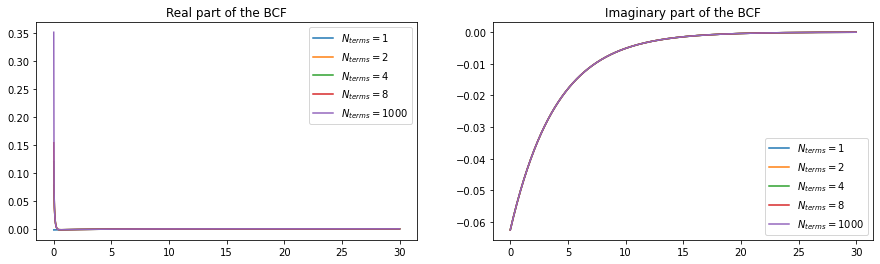

In [6]:
figure, axarray = plt.subplots(1, 2, figsize=(15, 4))
for i, N in enumerate(N_terms):
    axarray[0].plot(taus, np.real(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
    axarray[1].plot(taus, np.imag(alphas[i, :]), label="$N_{terms} = "+str(N)+"$")
axarray[0].legend()
axarray[0].set_title("Real part of the BCF")
axarray[1].legend()
axarray[1].set_title("Imaginary part of the BCF")
plt.show()

In [9]:
g, w = debye_spectral_density.get_debye_coefficients(1000, T, gamma, eta, use_alternative_expansion=True)

# Non-noise runs

In [33]:
N_terms_list = [1, 2, 3]
N_trunc = 40
N_steps = 10000

In [34]:
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'alternative_noise_generation' : True,
    'beta' : beta,
    'J' : debye_spectral_density.debye_spectral_density(w, eta, gamma)
}

In [35]:
psis = []
for i, N_terms in enumerate(N_terms_list):
    print("Computing N_terms =", N_terms)
    start = time.time()
    my_homps = homps.HOMPS_Engine(g[:N_terms], w[:N_terms], h, L, duration, N_steps, N_trunc, options)
    psi = my_homps.compute_realizations(1)
    psis.append(psi)
    end = time.time()
    print("took", end-start, "seconds")

Computing N_terms = 1
took 23.013132095336914 seconds
Computing N_terms = 2
took 84.86279845237732 seconds
Computing N_terms = 3
took 274.1922972202301 seconds


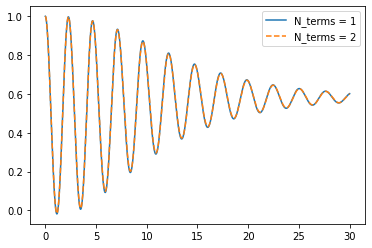

In [39]:
sigma_zs = compute_exp_val_nonlinear(psis[0], sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, label="N_terms = "+str(N_terms_list[0]))
sigma_zs = compute_exp_val_nonlinear(psis[1], sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "--", label="N_terms = "+str(N_terms_list[1]))
plt.legend()
plt.show()

# Runs with noise

In [61]:
N_terms_list = 1
N_trunc = 40
N_steps = 10000

In [62]:
options = {
    'linear' : False,
    'use_noise' : True,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'use_precise_svd' : False,
    'alternative_noise_generation' : True,
    'beta' : beta,
    'J' : lambda w : debye_spectral_density.debye_spectral_density(w, eta, gamma)
}

In [63]:
my_homps = homps.HOMPS_Engine(g[:N_terms], w[:N_terms], h, L, duration, N_steps, N_trunc, options)

In [64]:
psis_100 = my_homps.compute_realizations(100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

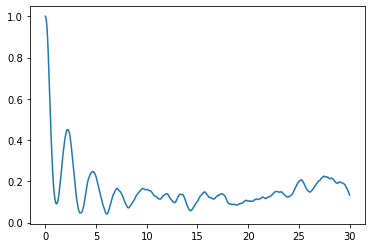

In [65]:
sigma_zs_100 = compute_exp_val_nonlinear(psis_100, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100)
plt.show()